In [61]:
# Basic Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

# For ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [2]:
from rdkit import rdBase
from rdkit import Chem
print(rdBase.rdkitVersion)

2020.09.1


In [15]:
!pip install git+https://github.com/samoturk/mol2vec

  Cloning https://github.com/samoturk/mol2vec to c:\users\ratul\appdata\local\temp\pip-req-build-smoa1f2u
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa


  Running command git clone -q https://github.com/samoturk/mol2vec 'C:\Users\ratul\AppData\Local\Temp\pip-req-build-smoa1f2u'


In [3]:
from gensim.models import word2vec
from mol2vec import features
from mol2vec import helpers
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

### Load and Preprocess Data

In [121]:
print(os.getcwd())

D:\Project\AP\Notebooks


In [5]:
# import data
drug_dataset = pd.read_csv("supercompf.csv")
drug_dataset.shape

(9002, 29)

In [6]:
drug_dataset.head()

,Unnamed: 0,ind1,ind2,vina_score,Unnamed: 3,smiles,mol,carbonyl,carboxylic acid,primary amine,...,ether,secondary amine,enamine,alene,vinyl,phenol,fluorine,chlorine,Bromine,Iodine
0,0,0,0,-10.6,ERGOTAMINE,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245df0>,3,0,0,...,1,0,0,0,2,0,0,0,0,0
1,1,1,1,-10.0,METERGOTAMINE,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245e40>,3,0,0,...,1,0,0,0,2,0,0,0,0,0
2,2,2,2,-9.9,ABBV-744,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245e90>,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,3,3,3,-9.9,DERQUANTEL,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245ee0>,1,0,0,...,2,1,1,0,2,0,0,0,0,0
4,4,4,4,-9.9,MERGOCRIPTINE,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245f30>,3,0,0,...,1,0,0,0,2,0,0,0,0,0


## Data Preprocessing

In [7]:
X_full_df = drug_dataset[['smiles','vina_score']]
print(X_full_df.shape)
X_full_df.head()

(9002, 2)


,smiles,vina_score
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.6
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.0
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,-9.9
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,-9.9
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,-9.9


In [8]:
X_full_df['molecules'] = X_full_df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
X_full_df.head()

C:\Users\ratul\anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,smiles,vina_score,molecules
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.6,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,-10.0,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,-9.9,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,-9.9,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,-9.9,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [9]:
# drop any missing value
X_full_df = X_full_df.dropna(axis=0)
X_full_df.shape

(9002, 3)

In [10]:
# target variables
y_full_df = X_full_df['vina_score']
print(y_full_df.shape)
y_full_df.head()

(9002,)


0   -10.6
1   -10.0
2    -9.9
3    -9.9
4    -9.9
Name: vina_score, dtype: float64

In [11]:
X_full_df = X_full_df.drop(['vina_score'], axis=1)
X_full_df.shape

(9002, 2)

In [12]:
X_full_df['sentence'] = X_full_df.apply(lambda x: MolSentence(mol2alt_sentence(x['molecules'], 1)), axis=1)
X_full_df.head()

,smiles,molecules,sentence
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840..."
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840..."
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 773607102..."
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 247601566..."
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 422715066, 3217380708, 1308598964..."


In [13]:
model = word2vec.Word2Vec.load('model_300dim.pkl')
X_full_df['mol2vec'] = [DfVec(x) for x in sentences2vec(X_full_df['sentence'], model, unseen='UNK')]
X_full_df.head()

,smiles,molecules,sentence,mol2vec
0,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840...","(300,) dimensional vector"
1,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 417788840...","(300,) dimensional vector"
2,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 773607102...","(300,) dimensional vector"
3,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1861965050, 2976816164, 247601566...","(300,) dimensional vector"
4,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 422715066, 3217380708, 1308598964...","(300,) dimensional vector"


In [14]:
X_full = np.array([x.vec for x in X_full_df['mol2vec']])
y_full = np.array(y_full_df)
print(X_full.shape)
print(y_full.shape)

(9002, 300)
(9002,)


In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=1)

In [16]:
# Feature scaling if necessary, Tree based models do not need it
standarize = StandardScaler()
standarize.fit(X_train)
X_train_scaled = standarize.transform(X_train)
X_test_scaled = standarize.transform(X_test)

In [17]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(7201, 300)
(1801, 300)


### Modelling and Training

In [18]:
def evaluate(model,X_test,y_test):
  preds = model.predict(X_test)
  mae = mean_absolute_error(y_test, preds)
  mse = mean_squared_error(y_test, preds)
  r_square = r2_score(y_test, preds)
  return mae,mse,r_square

In [27]:
# Defines and builds the lazyclassifier
lazy_clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = lazy_clf.fit(X_train, X_train, y_train, y_train)

# Performance table of the training set (80% subset)
predictions_train

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [07:37<00:00, 10.89s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,1.00,1.00,0.05,2.12
ExtraTreeRegressor,1.00,1.00,0.05,0.45
ExtraTreesRegressor,1.00,1.00,0.05,34.45
GaussianProcessRegressor,1.00,1.00,0.05,57.38
XGBRegressor,0.99,0.99,0.10,6.76
RandomForestRegressor,0.97,0.97,0.20,125.74
BaggingRegressor,0.95,0.96,0.23,12.05
HistGradientBoostingRegressor,0.94,0.94,0.27,5.53
LGBMRegressor,0.94,0.94,0.27,2.27


In [26]:
# Defines and builds the lazyclassifier
lazy_clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_test,predictions_test = lazy_clf.fit(X_train, X_test, y_train, y_test)

# Performance table of the test set (20% subset)
predictions_test

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [06:22<00:00,  9.12s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
NuSVR,0.79,0.82,0.47,18.78
SVR,0.79,0.82,0.47,19.65
LGBMRegressor,0.78,0.81,0.48,1.86
HistGradientBoostingRegressor,0.78,0.81,0.48,5.51
ExtraTreesRegressor,0.77,0.81,0.49,34.30
RandomForestRegressor,0.77,0.81,0.49,110.10
BaggingRegressor,0.75,0.79,0.51,12.59
GradientBoostingRegressor,0.74,0.78,0.52,58.92
KNeighborsRegressor,0.74,0.78,0.52,7.31


[(0.0, 1.0)]

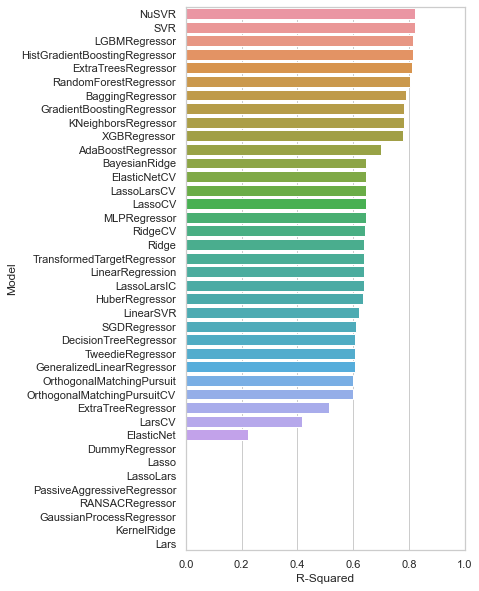

In [28]:
# Bar plot of R-squared values on test set
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_test.index, x="R-Squared", data=predictions_test)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

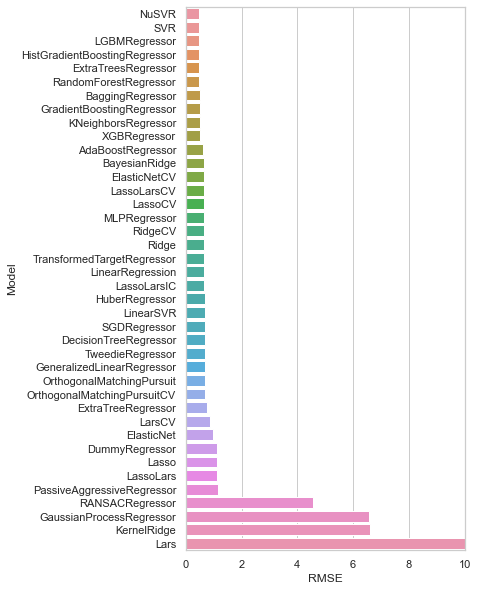

In [29]:
# Bar plot of RMSE values on test set
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_test.index, x="RMSE", data=predictions_test)
ax.set(xlim=(0, 10))

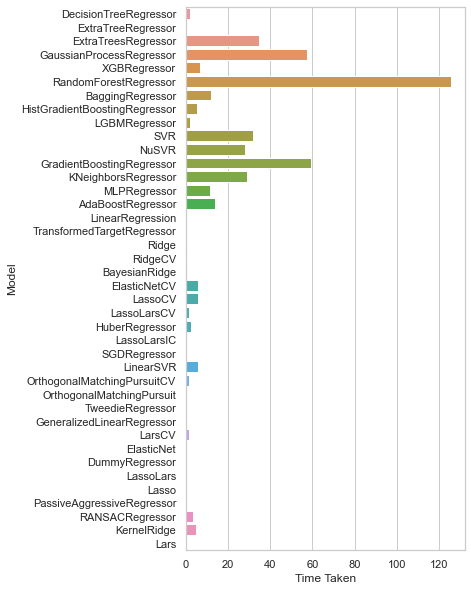

In [31]:
# Bar plot of calculation time for training
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)

## Training using Random Forest Regressor

In [32]:
model = RandomForestRegressor(n_estimators=250, max_depth=8, n_jobs=-1, random_state=1)
model.fit(X_train,y_train)

RandomForestRegressor(max_depth=8, n_estimators=250, n_jobs=-1, random_state=1)

In [33]:
# Compare preformance of the model on train and test data to account for bias and undefitting
print('Training data performance:')
mae,mse,r_square = evaluate(model, X_train, y_train)
print('MAE score : {:.4f}'.format(mae))
print('MSE score : {:.4f}'.format(mse))
print('r2 score : {:.4f}'.format(r_square))
print('Test data performance:')
mae,mse,r_square = evaluate(model, X_test, y_test)
print('MAE score : {:.4f}'.format(mae))
print('MSE score : {:.4f}'.format(mse))
print('r2 score : {:.4f}'.format(r_square))

Training data performance:
MAE score : 0.3014
MSE score : 0.1661
r2 score : 0.8640
Test data performance:
MAE score : 0.3675
MSE score : 0.2739
r2 score : 0.7806


In [34]:
params_grid = {'n_estimators': [i for i in range(200,1001,100)],
         'max_depth': [i for i in range(5,16,2)],
         'min_samples_split': [i for i in range(2,11)],
         'min_samples_leaf': [i for i in range(1,6)],
         'max_features': ['auto', 'sqrt'],
         'bootstrap': [True, False]}
print(params_grid)

{'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [5, 7, 9, 11, 13, 15], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_features': ['auto', 'sqrt'], 'bootstrap': [True, False]}


In [35]:
reg = RandomForestRegressor()
# Create the random search Random Forest
reg_tune = RandomizedSearchCV(estimator = reg, param_distributions = params_grid, n_iter = 10, cv = 5, verbose=2, n_jobs = -1, random_state=1)
# Fit the random search model
reg_tune.fit(X_train,y_train)
# Optimal score
print(reg_tune.best_score_)
# Get the optimal parameters
reg_tune.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 45.6min finished


0.7807415788979155


{'n_estimators': 600,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 15,
 'bootstrap': True}

In [36]:
reg_tune.best_estimator_

RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=600)

In [106]:
rfr_model = RandomForestRegressor(n_estimators=600, max_depth=15, min_samples_leaf=3, min_samples_split=3, n_jobs=-1, random_state=1)
rfr_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=600, n_jobs=-1, random_state=1)

In [107]:
mae,mse,r_square = evaluate(rfr_model, X_test, y_test)
print('MAE score : {:.4f}'.format(mae))
print('MSE score : {:.4f}'.format(mse))
print('r2 score : {:.4f}'.format(r_square))

MAE score : 0.3409
MSE score : 0.2424
r2 score : 0.8058


## Training using SVR

In [39]:
model2 = SVR(kernel='rbf')
model2.fit(X_train_scaled, y_train)

SVR()

In [40]:
# Compare preformance of the model on train and test data to account for bias and undefitting
print('Training data performance:')
mae,mse,r_square = evaluate(model2, X_train_scaled, y_train)
print(mae)
print(mse)
print(r_square)
print('Test data performance:')
mae,mse,r_square = evaluate(model2, X_test_scaled, y_test)
print(mae)
print(mse)
print(r_square)

Training data performance:
0.22666584041249324
0.1420441807901457
0.8836982288561485
Test data performance:
0.3177095462981116
0.22290259645009397
0.8214329669981865


In [62]:
svr_grid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
            'gamma': ['scale', 'auto']}
print(svr_grid)

{'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30], 'gamma': ['scale', 'auto']}


In [77]:
svr_reg = SVR(kernel='rbf')
# Create the random search SVR
svr_reg_tune = GridSearchCV(estimator = svr_reg, param_grid = svr_grid, cv = 5, verbose=2, n_jobs = -1)
# Fit the random search model
svr_reg_tune.fit(X_train_scaled,y_train)
# Optimal score
print(svr_reg_tune.best_score_)
# Get the optimal parameters
svr_reg_tune.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.7min finished


0.8054297011412309


{'C': 1, 'gamma': 'scale'}

In [78]:
svr_reg_tune.best_estimator_

SVR(C=1)

In [108]:
svr_model = SVR(kernel='rbf', C=1, gamma='scale')
svr_model.fit(X_train_scaled, y_train)

SVR(C=1)

In [109]:
print('Test set performance:')
mae,mse,r_square = evaluate(svr_model, X_test_scaled, y_test)
print('MAE score : {:.4f}'.format(mae))
print('MSE score : {:.4f}'.format(mse))
print('r2 score : {:.4f}'.format(r_square))

Test set performance:
MAE score : 0.3177
MSE score : 0.2229
r2 score : 0.8214


## Training using XGBRegressor

In [99]:
model3 = XGBRegressor(n_jobs=-1, random_state = 1)
model3.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
# Compare preformance of the model on train and test data to account for bias and undefitting
print('Training data performance:')
mae,mse,r_square = evaluate(model3, X_train, y_train)
print(mae)
print(mse)
print(r_square)
print('Test data performance:')
mae,mse,r_square = evaluate(model3, X_test, y_test)
print(mae)
print(mse)
print(r_square)

Training data performance:
0.07067884042385203
0.010011769033215977
0.9918026457376213
Test data performance:
0.3630061943354969
0.27414826324295416
0.7803801178204094


In [101]:
xgb_grid = {'n_estimators': [i for i in range(100,701,50)],
            'max_depth': [i for i in range(2,15,2)],
            'min_child_weight': [i for i in range(11)],
            'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
            'objective': ['reg:squarederror', 'reg:squaredlogerror']}
print(xgb_grid)

{'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700], 'max_depth': [2, 4, 6, 8, 10, 12, 14], 'min_child_weight': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'], 'objective': ['reg:squarederror', 'reg:squaredlogerror']}


In [102]:
xgb_reg = XGBRegressor()

# Create the random search Random Forest
xgb_reg_tune = RandomizedSearchCV(estimator = xgb_reg, param_distributions = xgb_grid, n_iter = 20, cv = 5, verbose = 2, 
                                random_state = 1, n_jobs = -1)

# Fit the random search model
xgb_reg_tune.fit(X_train, y_train)

# Optimal score
print(xgb_reg_tune.best_score_)
# Get the optimal parameters
xgb_reg_tune.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.7min finished


0.7626302226788594


{'tree_method': 'gpu_hist',
 'objective': 'reg:squarederror',
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 2}

In [103]:
xgb_reg_tune.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=150, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [110]:
xgb_model = XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror', n_estimators=150, min_child_weight=1,
                      max_depth=2, n_jobs=-1, random_state = 1)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=150, n_jobs=-1, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [111]:
print('Test set performance')
mae,mse,r_square = evaluate(xgb_model, X_test, y_test)
print('MAE score : {:.4f}'.format(mae))
print('MSE score : {:.4f}'.format(mse))
print('r2 score : {:.4f}'.format(r_square))

Test set performance
MAE score : 0.3599
MSE score : 0.2583
r2 score : 0.7931


In [118]:
# Define a function that compares all final models
def final_comparison(models, test_features, test_features_scaled, test_labels):
    scores = pd.DataFrame()
    for model in models:
        if model==svr_model:
            predictions = model.predict(test_features_scaled)
        else:
            predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        scores[type(model).__name__] = [mae, mse, r2]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2']
    return scores

In [119]:
scores = final_comparison([rfr_model, svr_model, xgb_model], X_test, X_test_scaled, y_test)
scores

,RandomForestRegressor,SVR,XGBRegressor
Mean Absolute Error,0.34,0.32,0.36
Mean Squared Error,0.24,0.22,0.26
R^2,0.81,0.82,0.79


*Note*: For using SVR model to make predictions on new data, scaling must be performed on the feature vector using the 'standarize' object defined above. For example, if the new feature vector is X, for applying SVR model we should use:
\begin{align} X\_ scaled &= strandarize.transform(X) \end{align} And then use X_scaled for furthur analysis